In [2]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

)
Using CUDA


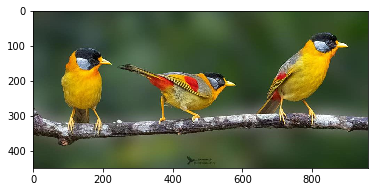

In [14]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

use_gpu = False

if torch.cuda.is_available():
    use_gpu = True

print(fcn)

for param in fcn.parameters():
    param.requires_grad = False

if use_gpu:
    print("Using CUDA")
    torch.cuda.empty_cache() 
    #fcn.cuda()

img = Image.open('image/segmentation/bird.jpg')
plt.imshow(img); plt.show()

In [15]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)
inp.cuda()

tensor([[[[-0.9363, -0.9534, -0.9534,  ..., -1.0733, -1.0562, -1.0390],
          [-0.9363, -0.9534, -0.9705,  ..., -1.0733, -1.0562, -1.0390],
          [-0.9192, -0.9363, -0.9534,  ..., -1.0562, -1.0390, -1.0219],
          ...,
          [-0.2513, -0.2342, -0.2342,  ..., -1.2445, -1.2445, -1.2445],
          [-0.2684, -0.2513, -0.2513,  ..., -1.2445, -1.2617, -1.2617],
          [-0.2856, -0.2684, -0.2513,  ..., -1.2617, -1.2788, -1.2788]],

         [[-0.3725, -0.3901, -0.3901,  ..., -0.5651, -0.5476, -0.5301],
          [-0.3725, -0.3901, -0.4076,  ..., -0.5651, -0.5476, -0.5301],
          [-0.3550, -0.3725, -0.3901,  ..., -0.5651, -0.5476, -0.5301],
          ...,
          [ 0.0651,  0.0826,  0.0826,  ..., -0.8627, -0.8627, -0.8627],
          [ 0.0476,  0.0651,  0.0651,  ..., -0.8803, -0.8803, -0.8803],
          [ 0.0301,  0.0476,  0.0651,  ..., -0.8978, -0.8978, -0.8978]],

         [[-0.5844, -0.6018, -0.6018,  ..., -1.0550, -1.0550, -1.0376],
          [-0.6018, -0.6193, -

In [16]:
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [17]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)

(224, 224)


In [18]:
# Define the helper function
def decode_segmap(image, nc=21): 
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

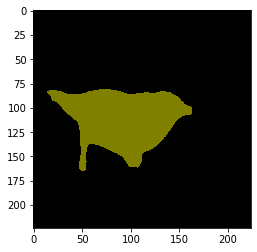

In [19]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [20]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

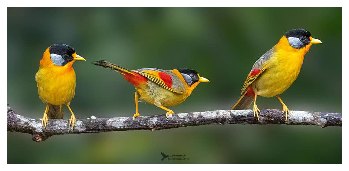

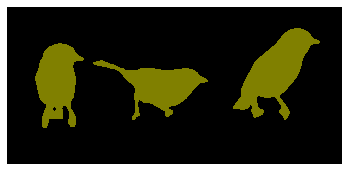

In [21]:
segment(fcn, 'image/segmentation/bird.jpg')

In [22]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [25]:
torch.cuda.empty_cache() 
segment(dlab, path='image/segmentation/bird.jpg', show_orig=False)

RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 8.00 GiB total capacity; 5.91 GiB already allocated; 22.04 MiB free; 77.41 MiB cached)